# Notebook 01:
Merging data and visualizationa:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pickle

C:\Users\merto\AppData\Local\Temp\ipykernel_8264\4079619088.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Step1:

Combining previous DataFrames (all_rads, humidity_frame, temperature_frame,\
theoretical_radiation) together:

In [2]:
#Loading previous data:

with open(r'..\data\interim\01_reading_data\all_rads.pkl', 'rb') as f:
    all_rads= pickle.load(f)

with open(r'..\data\external\02_fetching_mathematica\humidity_frame.pkl', 'rb') as f:
    humidity_frame = pickle.load(f)

with open(r'..\data\external\02_fetching_mathematica\temperature_frame.pkl', 'rb') as f:
    temperature_frame = pickle.load(f)

with open(r'..\data\external\03_theoretical_radiation\theoretical_radiations.pkl', 'rb') as f:
    theoretical_radiation = pickle.load(f)

In [3]:
all_rads.head()

,time,city,radiation
0,1993-01-01,BND,12.62
1,1993-01-01,ESF,12.90
3,1993-01-01,KRM,13.38
4,1993-01-01,MSH,10.42
5,1993-01-01,SHZ,14.62


In [4]:
#The radiation column of all_rads DataFrame contains the available radiation values,
#So it's name should be changed to ava_rad.

all_rads.rename(columns={'radiation':'ava_rad'}, inplace=True)

all_rads.head()

,time,city,ava_rad
0,1993-01-01,BND,12.62
1,1993-01-01,ESF,12.90
3,1993-01-01,KRM,13.38
4,1993-01-01,MSH,10.42
5,1993-01-01,SHZ,14.62


In [5]:
#Temperature & relative humidity values from Dataframes temperature_frame
#and humidity_frame should be added to the all_rads DataFrame.

def add_temperature(row):
    return temperature_frame.loc[row.time, row.city]

all_rads['temp'] = all_rads.apply(add_temperature, axis=1)

def add_humidity(row):
    return humidity_frame.loc[row.time, row.city]

all_rads['rel_hum'] = all_rads.apply(add_humidity, axis=1)

all_rads.head()

,time,city,ava_rad,temp,rel_hum
0,1993-01-01,BND,12.62,19.11,0.782
1,1993-01-01,ESF,12.90,0.44,0.462
3,1993-01-01,KRM,13.38,4.83,0.576
4,1993-01-01,MSH,10.42,-0.06,0.732
5,1993-01-01,SHZ,14.62,4.61,0.602


In [6]:
#Since the temperature_frame and humidity_frame contain Nan values,
#Nan values may have been added to the all_rads DataFrame, so we should
#omit possible added Nan values.

all_rads.dropna(inplace=True)

In [7]:
#Extracting year, month and day of year from the time column,
#and adding them to the all_rads DataFrame.

all_rads['year'] = all_rads.time.apply(lambda x: x.year)
all_rads['month'] = all_rads.time.apply(lambda x: x.month)
all_rads['dom'] = all_rads.time.dt.day #dom stands for day of month
all_rads['doy'] = all_rads.time.apply(lambda x: x.day_of_year) #doy stands for day of year

all_rads.head()

,time,city,ava_rad,temp,rel_hum,year,month,dom,doy
0,1993-01-01,BND,12.62,19.11,0.782,1993,1,1,1
1,1993-01-01,ESF,12.90,0.44,0.462,1993,1,1,1
3,1993-01-01,KRM,13.38,4.83,0.576,1993,1,1,1
4,1993-01-01,MSH,10.42,-0.06,0.732,1993,1,1,1
5,1993-01-01,SHZ,14.62,4.61,0.602,1993,1,1,1


In [8]:
#Since the spells of yazd city in DataFrames all_rads and theoretical_radiations
#are not the same, we have change the spells to a unique name.

all_rads.replace('yazd', 'YAZD', inplace=True)
theoretical_radiation.rename(columns={'Yazd': 'YAZD'}, inplace=True)

In [9]:
#Adding extraterrestrial IR radiation to all_rads DataFrame,
#from the theoretical_radiation DataFrame.

def add_et_ir(row):
    return theoretical_radiation.loc[row.doy, row.city]

all_rads['et_rad'] = all_rads.apply(add_et_ir, axis=1)

all_rads.head()

,time,city,ava_rad,temp,rel_hum,year,month,dom,doy,et_rad
0,1993-01-01,BND,12.62,19.11,0.782,1993,1,1,1,21.652331
1,1993-01-01,ESF,12.90,0.44,0.462,1993,1,1,1,18.352701
3,1993-01-01,KRM,13.38,4.83,0.576,1993,1,1,1,19.798337
4,1993-01-01,MSH,10.42,-0.06,0.732,1993,1,1,1,16.104011
5,1993-01-01,SHZ,14.62,4.61,0.602,1993,1,1,1,20.216349


In [10]:
#Adding absolute humidity to all_rads DataFrame.
#The t_sh dictionary maps temperature(degree celsius) to saturated humidity(g/kg).

t_sh = {
    -25:0.706, -24:0.769, -23:0.837, -22:0.911, -21:0.990, -20:1.075,
    -19:1.167, -18:1.265, -17:1.371, -16:1.485, -15:1.607, -14:1.737,
    -13:1.877, -12:2.027, -11:2.188, -10:2.360, -9:2.543, -8:2.739,
    -7:2.948, -6:3.171, -5:3.409, -4:3.662, -3:3.932, -2:4.219, -1:4.524,
    0:4.849, 1:5.193, 2:5.560, 3:5.948, 4:6.360, 5:6.797, 6:7.260, 7:7.750,
    8:8.269, 9:8.818, 10:9.398, 11:10.011, 12:10.660, 13:11.343, 14:12.065,
    15:12.826, 16:13.630, 17:14.474, 18:15.365, 19:16.303, 20:17.290, 21:18.328,
    22:19.420, 23:20.566, 24:21.770, 25:23.037, 26:24.364, 27:25.760, 28:27.220,
    29:28.750, 30:30.355, 31:32.036, 32:33.796, 33:35.64, 34:37.566, 35:39.580,
    36:41.690, 37:43.890, 38:46.190, 39:48.590, 40:51.100, 41:53.72, 42:56.450,
    43:59.290, 44:62.260, 45:65.350, 46:68.570, 47:71.920, 48:75.410, 49:79.050,
    50:82.830}

sat_hum = all_rads.temp.apply(lambda x: t_sh[round(x)])
all_rads['abs_hum'] = sat_hum * all_rads.rel_hum

all_rads.head()

,time,city,ava_rad,temp,rel_hum,year,month,dom,doy,et_rad,abs_hum
0,1993-01-01,BND,12.62,19.11,0.782,1993,1,1,1,21.652331,12.748946
1,1993-01-01,ESF,12.90,0.44,0.462,1993,1,1,1,18.352701,2.240238
3,1993-01-01,KRM,13.38,4.83,0.576,1993,1,1,1,19.798337,3.915072
4,1993-01-01,MSH,10.42,-0.06,0.732,1993,1,1,1,16.104011,3.549468
5,1993-01-01,SHZ,14.62,4.61,0.602,1993,1,1,1,20.216349,4.091794


In [11]:
#Adding clearness index(kt) to the DataFrame.
#Omiting samples with kt >= 1 values.

all_rads['kt'] = all_rads.ava_rad / all_rads.et_rad
all_rads = all_rads.where(all_rads.kt < 1).dropna()

all_rads.head()

,time,city,ava_rad,temp,rel_hum,year,month,dom,doy,et_rad,abs_hum,kt
0,1993-01-01,BND,12.62,19.11,0.782,1993.0,1.0,1.0,1.0,21.652331,12.748946,0.582847
1,1993-01-01,ESF,12.90,0.44,0.462,1993.0,1.0,1.0,1.0,18.352701,2.240238,0.702894
3,1993-01-01,KRM,13.38,4.83,0.576,1993.0,1.0,1.0,1.0,19.798337,3.915072,0.675814
4,1993-01-01,MSH,10.42,-0.06,0.732,1993.0,1.0,1.0,1.0,16.104011,3.549468,0.647044
5,1993-01-01,SHZ,14.62,4.61,0.602,1993.0,1.0,1.0,1.0,20.216349,4.091794,0.723177


In [12]:
#Changing columns order of the all_rads DataFrame.
#Changing DataFrame name form all_rads to data.

all_rads = all_rads[['time', 'year', 'month', 'dom', 'doy', 'city', 'temp',
                     'rel_hum', 'abs_hum', 'ava_rad','et_rad', 'kt']]
data = all_rads

data.head()

,time,year,month,dom,doy,city,temp,rel_hum,abs_hum,ava_rad,et_rad,kt
0,1993-01-01,1993.0,1.0,1.0,1.0,BND,19.11,0.782,12.748946,12.62,21.652331,0.582847
1,1993-01-01,1993.0,1.0,1.0,1.0,ESF,0.44,0.462,2.240238,12.90,18.352701,0.702894
3,1993-01-01,1993.0,1.0,1.0,1.0,KRM,4.83,0.576,3.915072,13.38,19.798337,0.675814
4,1993-01-01,1993.0,1.0,1.0,1.0,MSH,-0.06,0.732,3.549468,10.42,16.104011,0.647044
5,1993-01-01,1993.0,1.0,1.0,1.0,SHZ,4.61,0.602,4.091794,14.62,20.216349,0.723177


In [13]:
#Pickling data as combined_data.pkl
#This data is not cleaned.

with open(r'..\data\interim\04_data_merging\combined_data.pkl', 'wb') as f:
    pickle.dump(data, f)

## Droping outliers:

In [14]:
#Finding out what percentage of data is cosiderd outlier for each city.
#Data points witch are 2 times of STD further from the mean are outliers.
#Saving upper and lower limits of outliers for each city in limits dictionary.

cities = data.city.unique()
limits = {}
outlier_perc = {}

for city in cities:
    kt = data[data.city == city]['kt']
    mean, std = kt.mean(), kt.std()
    lower, upper = mean - 2*std, mean + 2*std
    limits[city] = {'lower':lower, 'upper':upper}
    valid_perc = ((lower < kt) & (kt < upper)).mean() * 100
    outlier_perc[city] = 100 -valid_perc

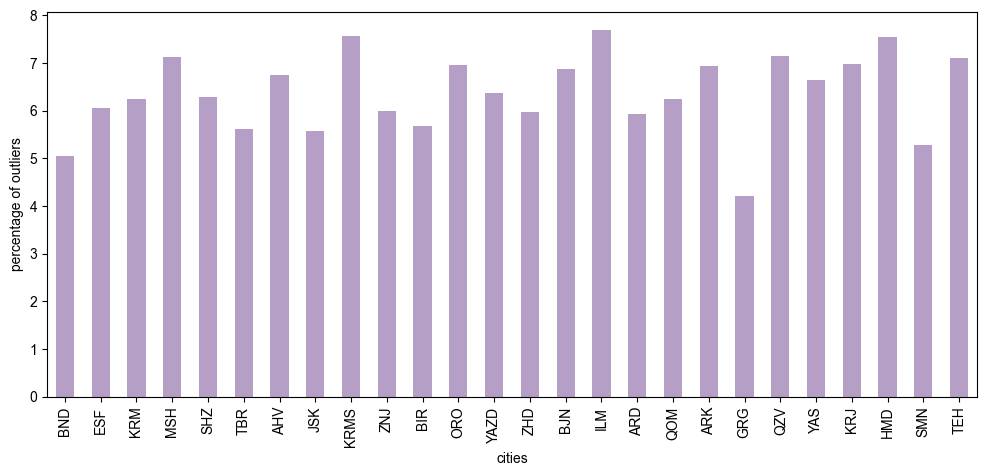

In [15]:
#Ploting outlier percentage of each city.

fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(outlier_perc, color='indigo',width=0.51, alpha=0.4)
sns.set_style("darkgrid")

ax.set_xlabel('cities')
ax.set_xticks(ticks=range(len(outlier_perc)), labels=outlier_perc.keys(), rotation=90)
ax.set_ylabel('percentage of outliers')
pass

In [16]:
#Removing outliers from the data DataFrame.

data.loc[:, 'lower'] = data.city.apply(lambda x: limits[x]['lower'])
data.loc[:, 'upper'] = data.city.apply(lambda x: limits[x]['upper'])

data['not_outlier'] = (data.lower < data.kt) & (data.kt < data.upper)
data['not_outlier'].mean()

data = data[data['not_outlier']]
data.drop(['lower', 'upper', 'not_outlier'], axis=1, inplace=True)

C:\Users\merto\AppData\Local\Temp\ipykernel_8264\1031631846.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(['lower', 'upper', 'not_outlier'], axis=1, inplace=True)


## Data visualization:

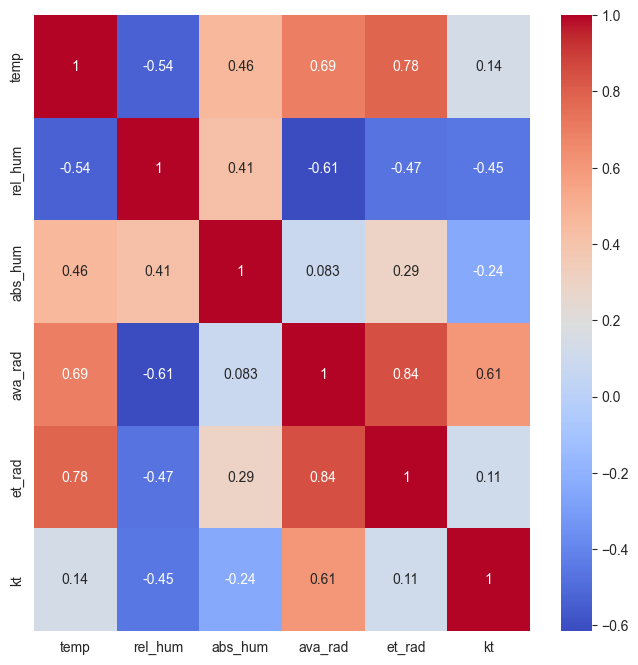

In [17]:
#Ploting correlation matrix.

corr = data[['temp', 'rel_hum', 'abs_hum', 'ava_rad', 'et_rad', 'kt']].corr()

fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(corr, annot=True, ax=ax, cmap="coolwarm")
pass

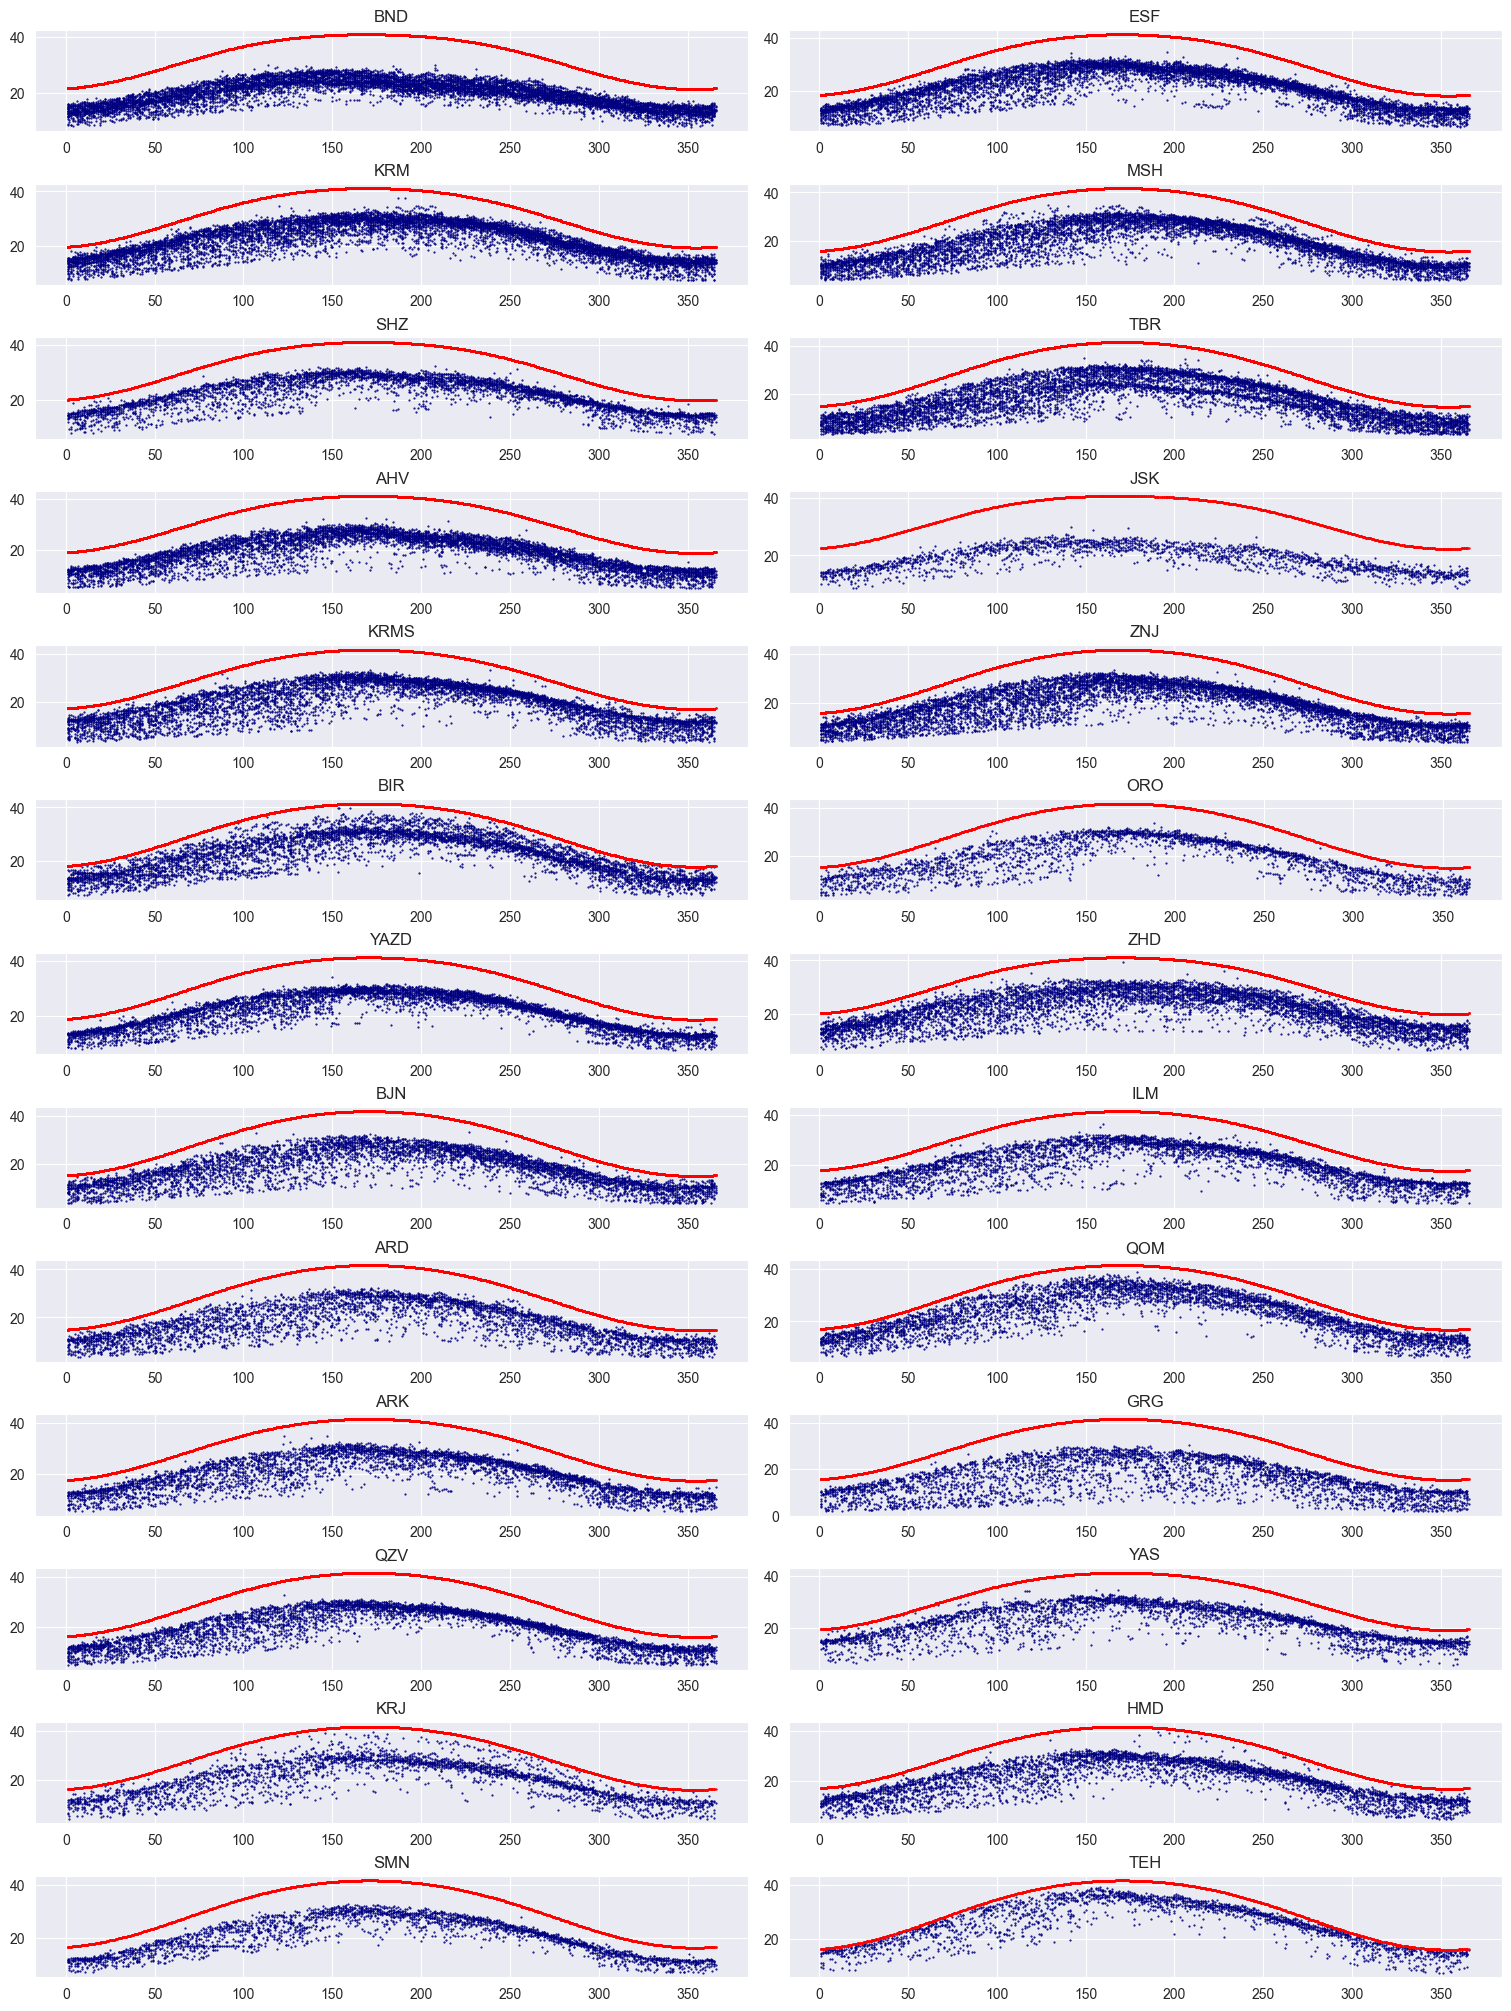

In [18]:
#Scater ploting each city available radiation,
#and extratrestrial radiation.

fig, axes = plt.subplots(13, 2, figsize=(15, 20), layout='constrained')

for ax, city in zip(axes.ravel(), cities):
    city_data = data.where(data.city == city)
    ax.scatter(city_data.doy, city_data.ava_rad, s=0.3, c='navy')
    ax.scatter(city_data.doy, city_data.et_rad, s=0.5, c='red')
    ax.set_title(city)

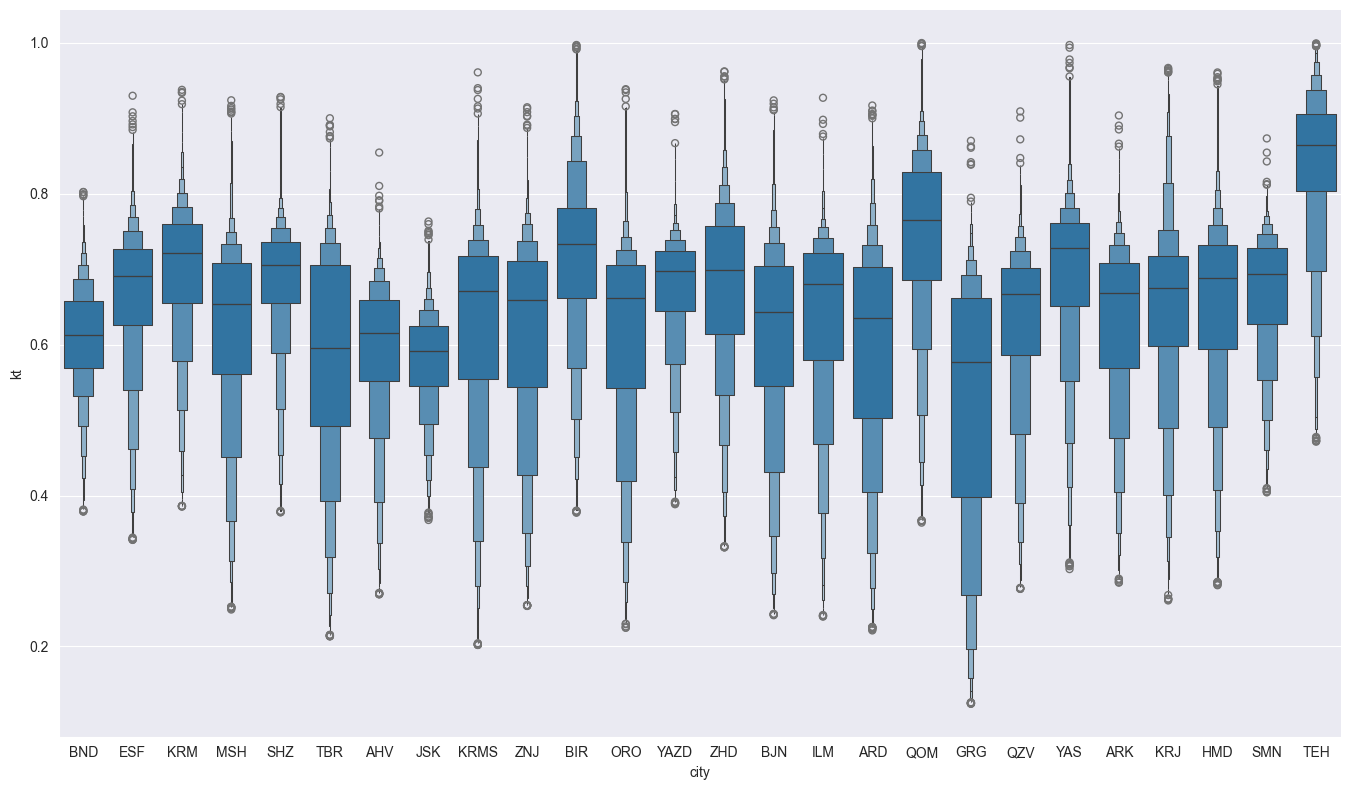

In [19]:
#Ploting distribution box plot of kt(clearness), for each city.

sns.catplot(data=data, x='city', y='kt', kind='boxen', height=8, aspect=1.7)

### Removing TEH(Tehran city) from data:

since kt values of tehran are much higher than other cities,
it's data is not reliable and should be omited!

In [20]:
data = data[data.city != 'TEH']
cities = data.city.unique()

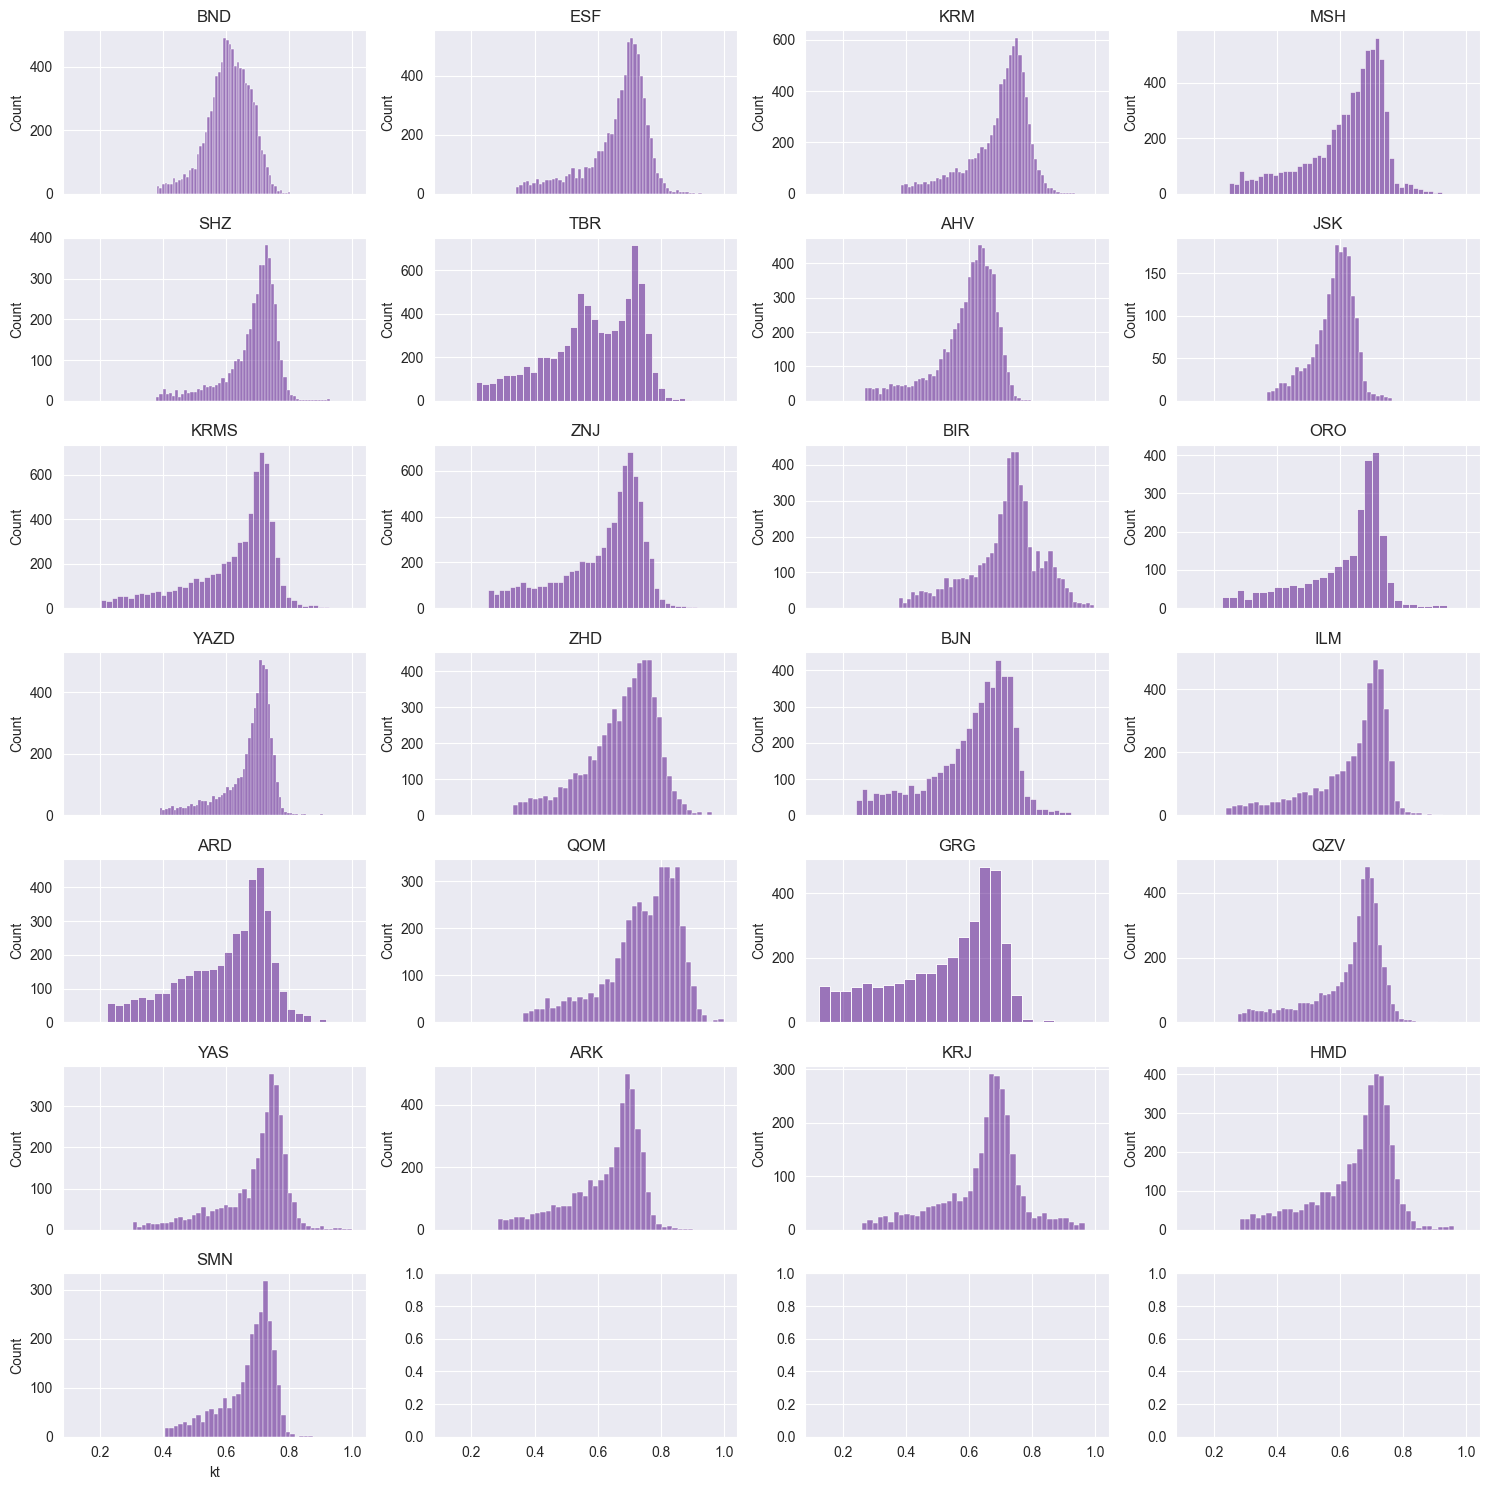

In [21]:
#Histogram ploting kt values for each city.

fig, axes = plt.subplots(7, 4, figsize=(15, 15), sharex=True)

for city, ax in zip(cities, axes.ravel()):
    city_data = data[data.city == city]
    sns.histplot(city_data.kt, color='indigo', alpha=0.5, ax=ax)
    ax.set_title(city)
    #ax.hist(city_data.kt, bins=30)

plt.tight_layout()

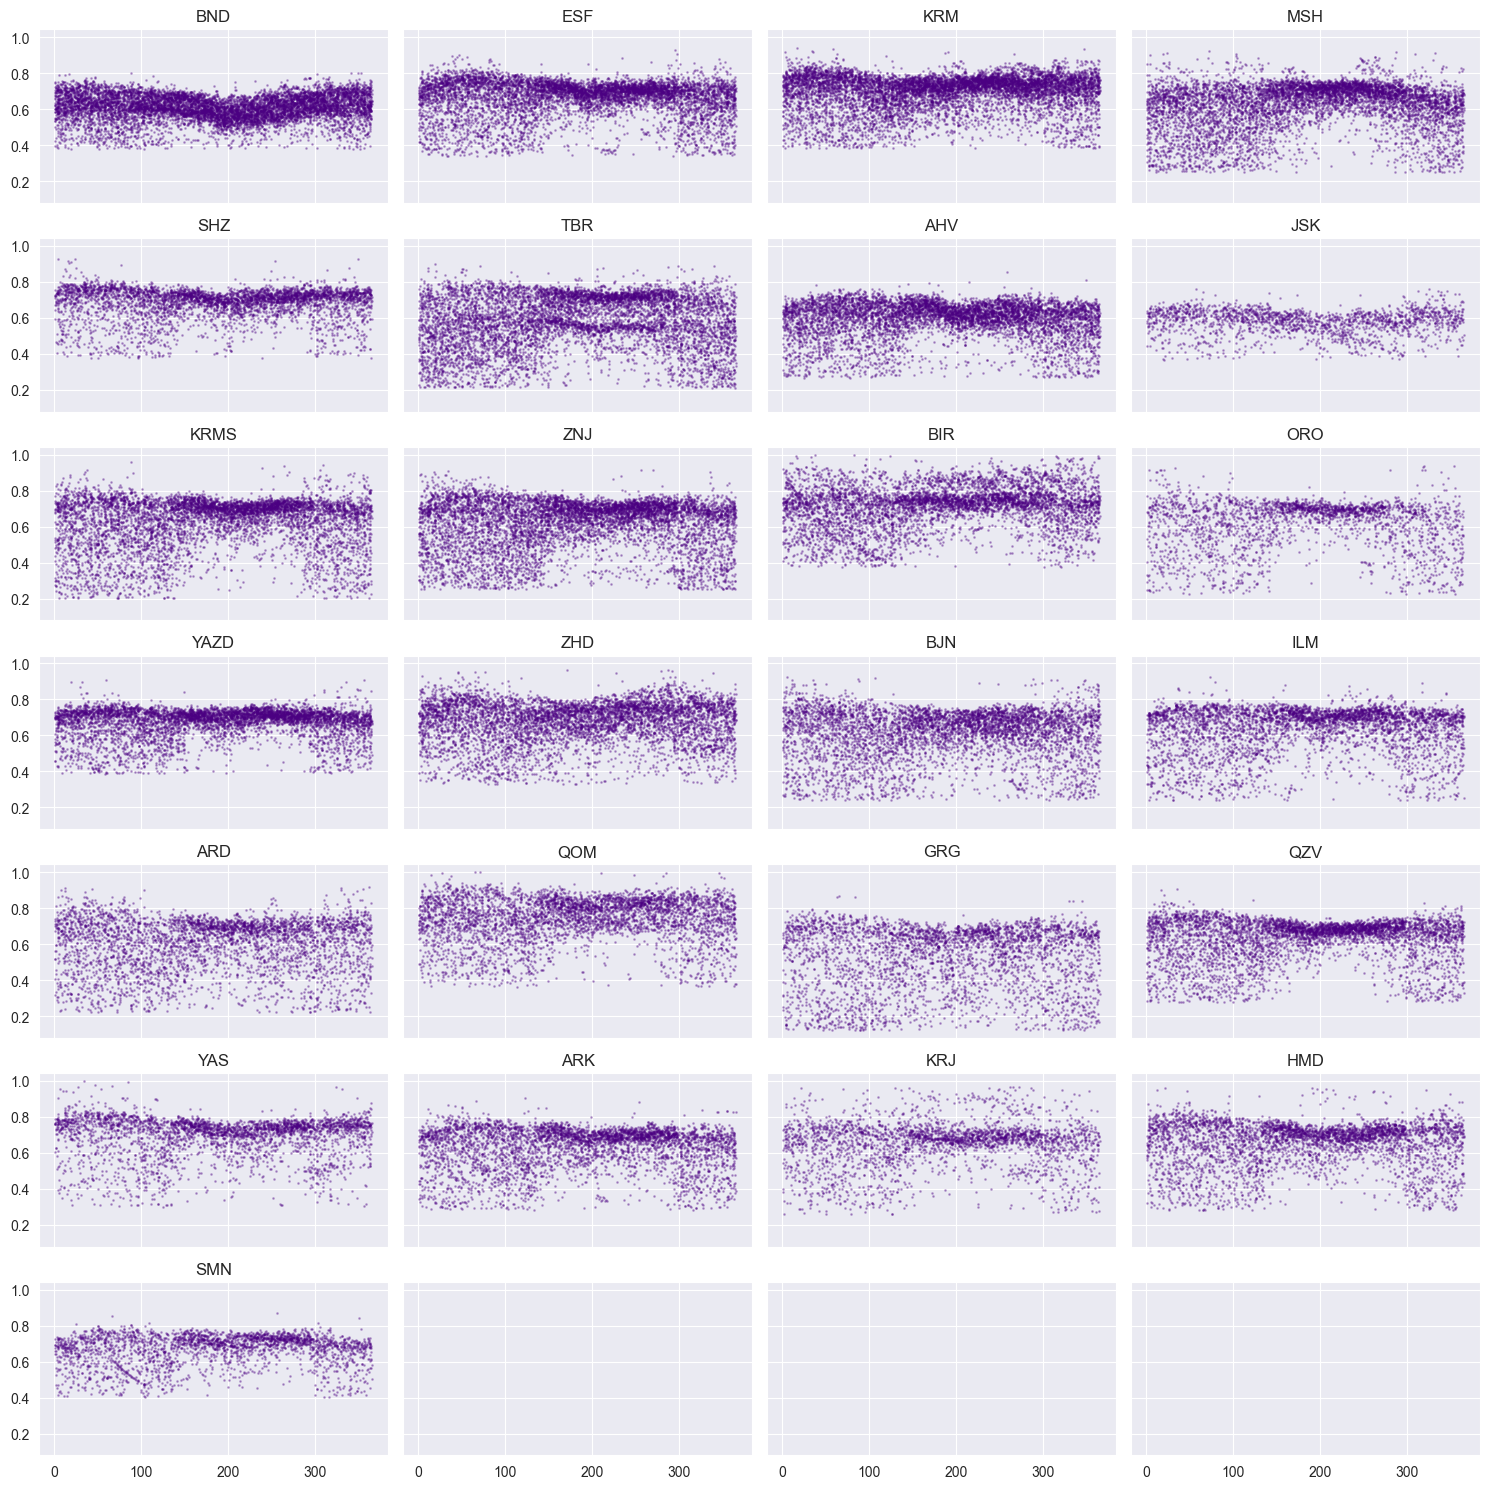

In [22]:
#Scatter ploting kt(clearness) and doy(day of year), for each city.

fig, axes = plt.subplots(7, 4, figsize=(15, 15), sharex=True, sharey=True)

for city, ax in zip(cities, axes.ravel()):
    city_data = data[data.city == city]
    ax.scatter(city_data.doy, city_data.kt, color='indigo', alpha=0.3, s=1)
    ax.set_title(city)

plt.tight_layout()

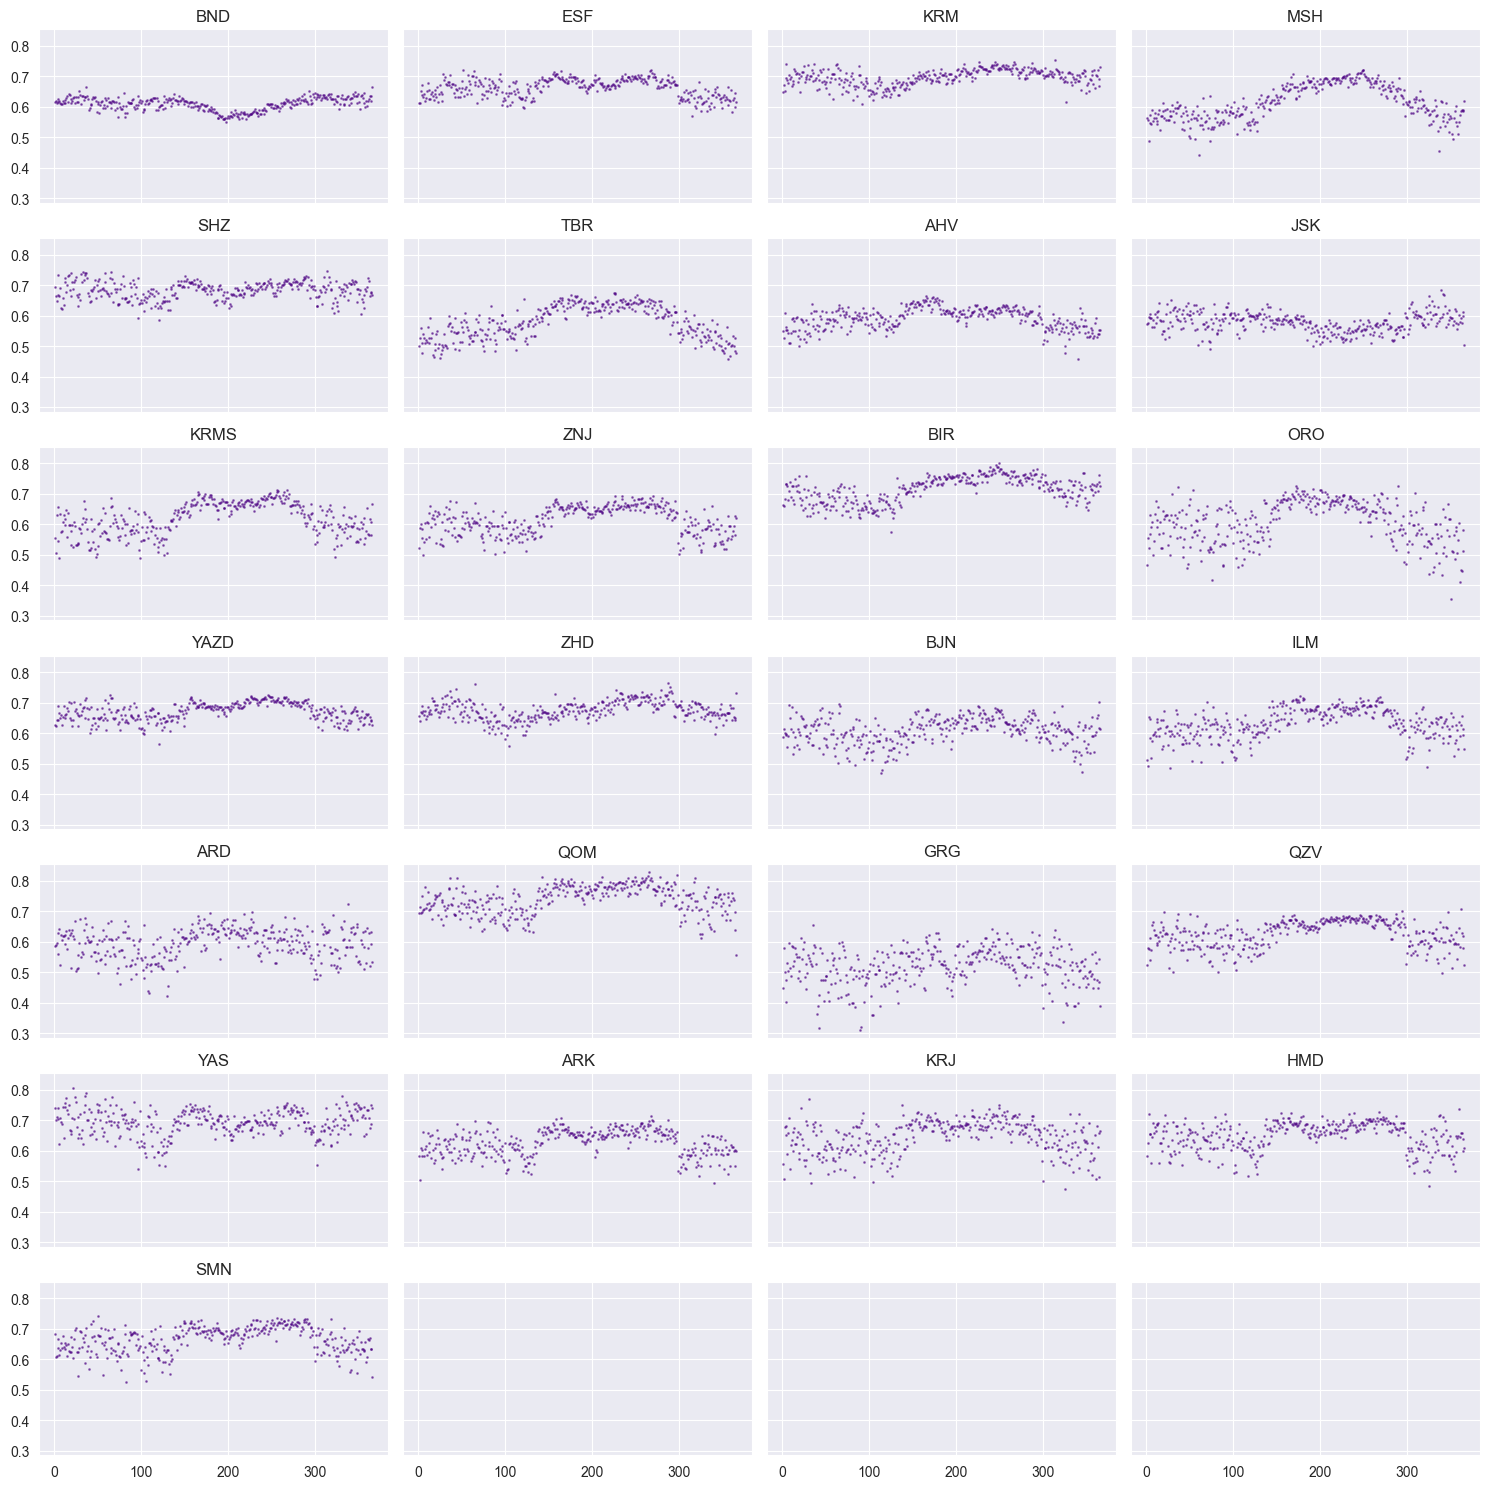

In [23]:
#Averaging kt over year for each city, and scatter ploting it.

daily_avr_kt = data.groupby(['doy', 'city']).kt.mean()
daily_avr_kt = pd.DataFrame(daily_avr_kt)
daily_avr_kt.reset_index(inplace=True)

fig, axes = plt.subplots(7, 4, figsize=(15, 15), sharex=True, sharey=True)

for city, ax in zip(cities, axes.ravel()):
    city_data = daily_avr_kt[daily_avr_kt.city == city]
    ax.scatter(city_data.doy, city_data.kt, color='indigo', alpha=0.5, s=1)
    ax.set_title(city)

plt.tight_layout()

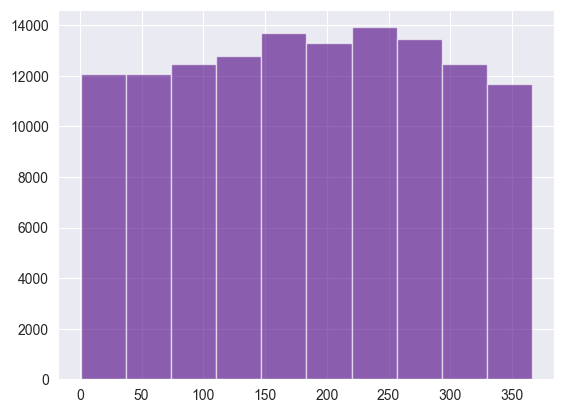

In [24]:
#Histogram ploting doy(day of year) of all cities.
#To observe the overal sampeling distribution.

plt.hist(data.doy, color='indigo', alpha=0.6)
pass

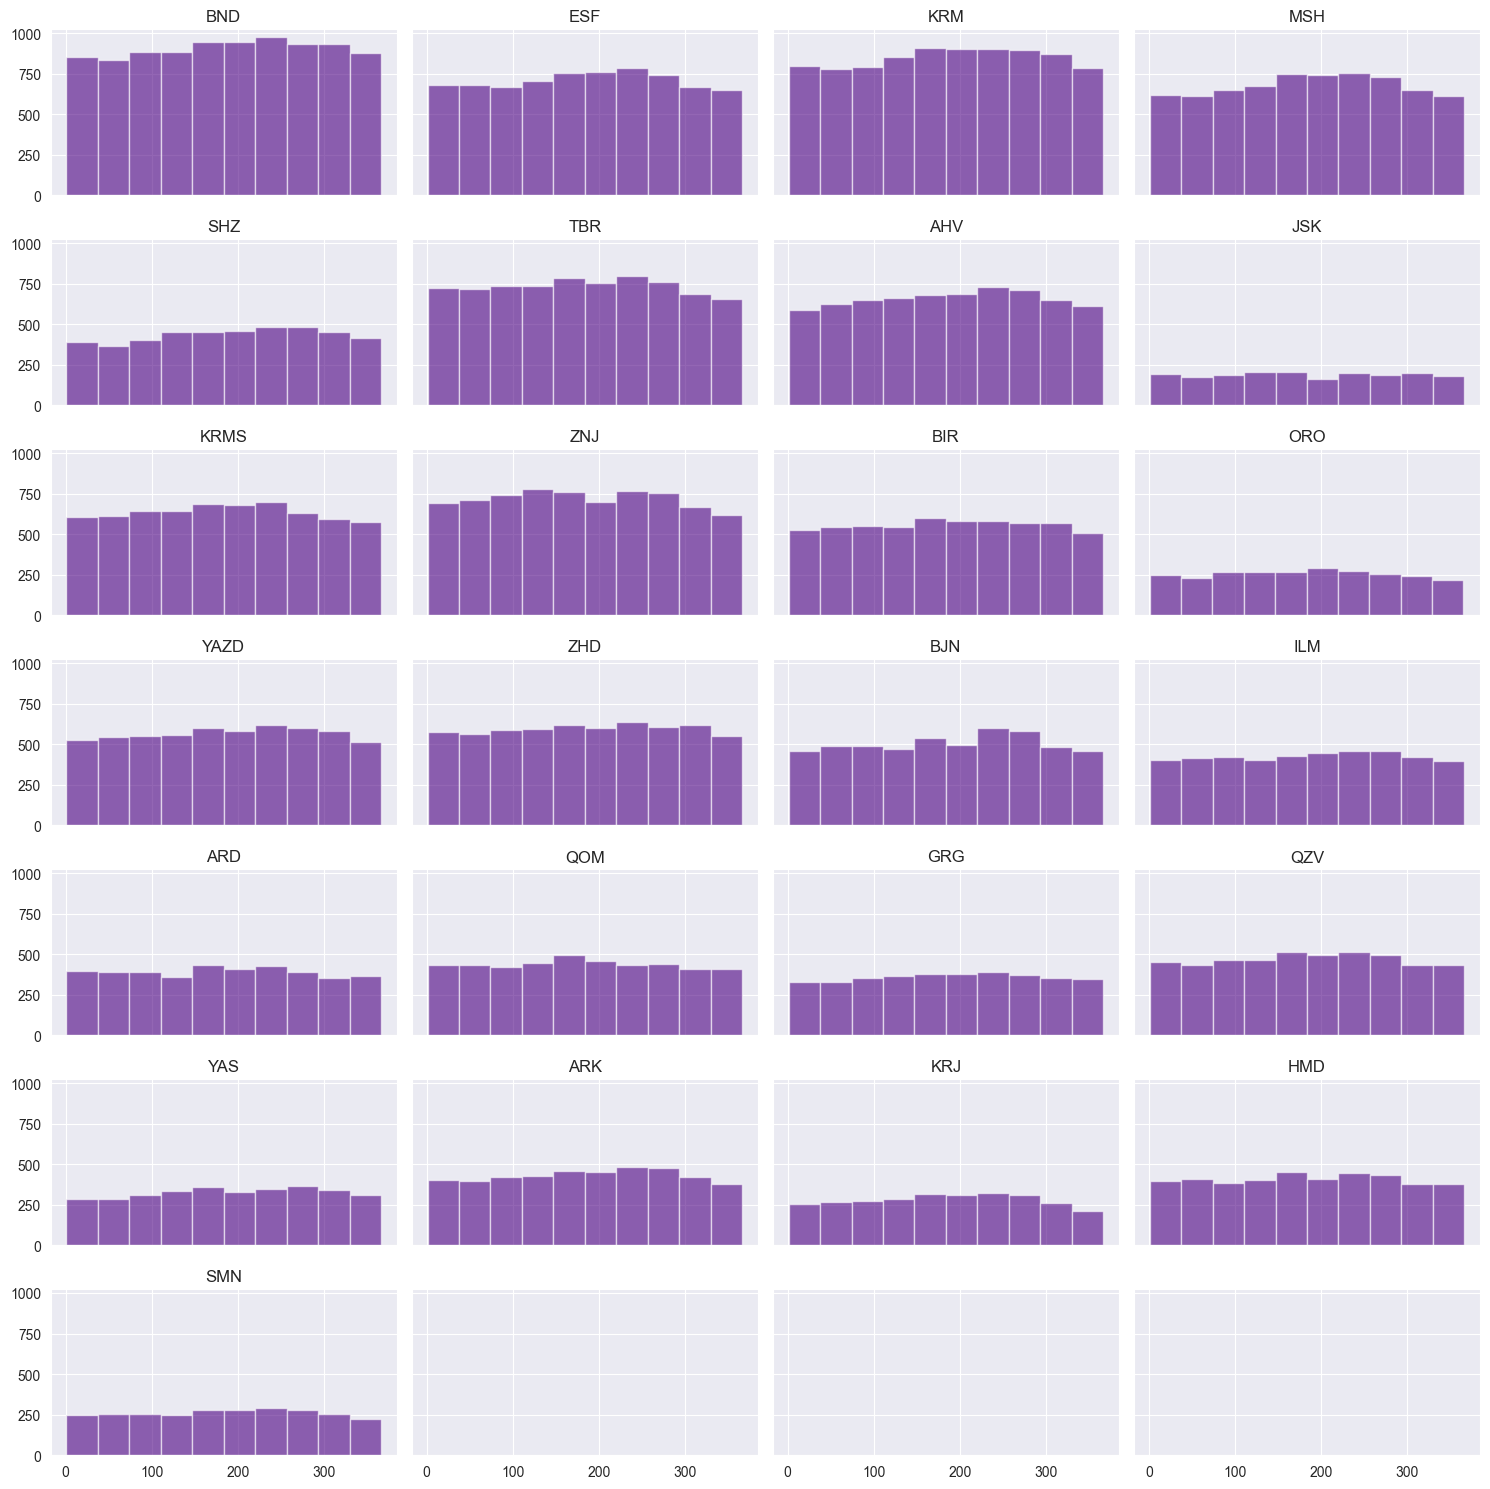

In [25]:
#Histogram ploting doy(day of year) for each city.
#To observe sampeling distribution.

fig, axes = plt.subplots(7, 4, figsize=(15, 15), sharex=True, sharey=True)

for city, ax in zip(cities, axes.ravel()):
    city_data = data[data.city == city]
    ax.hist(city_data.doy, color='indigo', alpha=0.6)
    ax.set_title(city)

plt.tight_layout()

In [26]:
#Pickling data as combined_data.pkl
#Outlier are removed from this data.

with open(r'..\data\interim\04_data_merging\cleaned_data.pkl', 'wb') as f:
    pickle.dump(data, f)

## Conclusion:
In this notebook:

1. All previous datasets are merged together.
2. Outliers are removed.
3. The final DataFramed is pickled for further processes.